# Multi-factor Model
## Instructions
The following project consists of functions and steps to implement a portfolio construction of alpha factors optimized with risk models.  

## Packages
We implement the functions using packages like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). 

Additionally, we import `project_helper` that contains utility functions and graph functions.

### Install Packages

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade pip 
!{sys.executable} -m pip install --upgrade wheel setuptools build
!{sys.executable} -m pip install -r requirements.txt

In [5]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
#import project_helper

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

import yfinance as yf

### Load Packages


## Data Bundle
We'll be using Zipline to handle our data. We've created a end of day data bundle for this project. Run the cell below to register this data bundle in zipline.

In [55]:
# file paths
cl_path = '/Users/martinescobarsalgueiro/Library/CloudStorage/OneDrive-Personal'
in_path = '/Users/mescobars/dev/datasets/prod/'
out_path = '/Users/mescobars/dev/datasets/prod/'

In [73]:
# File name
file = 'eod_quotemedia_p3.csv'
# Construct the full file path
path = in_path + file
# Read the CSV file
df = pd.read_csv(path, parse_dates=['date'], index_col=False)

# set the universe
percent_top_dollar = 0.022
high_volume_symbols = project_helper.large_dollar_volume_stocks(df, 'adj_close', 'adj_volume', percent_top_dollar)
df = df[df['ticker'].isin(high_volume_symbols)]

close = df.reset_index().pivot(index='date', columns='ticker', values='adj_close')
volume = df.reset_index().pivot(index='date', columns='ticker', values='adj_volume')
dividends = df.reset_index().pivot(index='date', columns='ticker', values='dividends')

In [ ]:
print(dividends.tail(20))

In [ ]:
# Create a fourth dataset 'sector' where values are 1 for rows with dividends > 0, else 0
sector = (dividends.fillna(0) > 0).astype(int)
sector

In [75]:
def generate_returns(prices):
    """
    Generate returns for ticker and date.

    Parameters
    ----------
    prices : DataFrame
        Price for each ticker and date

    Returns
    -------
    returns : Dataframe
        The returns for each ticker and date
    """
    #TODO: Implement function
    returns = prices / prices.shift(1) - 1
    
    return returns

In [ ]:
five_year_returns = generate_returns(close)
five_year_returns = five_year_returns.dropna()
five_year_returns

In [ ]:
type(five_year_returns)

### View Data
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [ ]:
#universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

#universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
#universe_tickers

## Get Returns
Not that we have our pipeline built, let's access the returns data. We'll start by building a data portal.

In [6]:
from zipline.data.data_portal import DataPortal


data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

To make the code easier to read, we've built the helper function `get_pricing` to get the pricing from the data portal. 

In [7]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

### View Data
Let's get returns data for our risk model using the `get_pricing` function. For this model, we'll be looking back to 5 years of data.

In [ ]:
five_year_returns = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0)

five_year_returns

## Data Importing and Processing

In [6]:
# Read and print the stock tickers that make up S&P500
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
print(tickers.head())

tickers.Symbol.to_list()[:5]

  Symbol             Security             GICS Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois  2012-12-31   
4  IT Consulting & Other Services          Dublin, Ireland  2011-07-06   

       CIK      Founded  
0    66740         1902  
1    91142         1916  
2     1800         1888  
3  1551152  2013 (1888)  
4  1467373         1989  


['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']

In [7]:
# Get the data for this tickers from yahoo finance
start_date = '2019-12-31'
end_date = '2024-12-31'


In [8]:
data = yf.download(tickers.Symbol.to_list(), start_date, end_date, auto_adjust=True)

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2019-12-31 -> 2024-12-31)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [9]:
df = data.stack(level=1).reset_index().sort_values(by=["Ticker", "Date"])

/var/folders/18/blnm1nm50696kqjfj926l25r0000gn/T/ipykernel_3465/1648502045.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = data.stack(level=1).reset_index().sort_values(by=["Ticker", "Date"])


In [10]:
# Ensure 'Date' in both datasets is in the same timezone format before merging
df["Date"] = pd.to_datetime(df["Date"]).dt.date


In [11]:
def large_dollar_volume_stocks(df, price_column, volume_column, top_percent):
    """
    Get the stocks with the largest dollar volume stocks.

    Parameters
    ----------
    df : DataFrame
        Stock prices with dates and ticker symbols
    price_column : str
        The column with the price data in `df`
    volume_column : str
        The column with the volume in `df`
    top_percent : float
        The top x percent to consider largest in the stock universe

    Returns
    -------
    large_dollar_volume_stocks_symbols : List of str
        List of of large dollar volume stock symbols
    """
    dollar_traded = df.groupby('Ticker').apply(lambda row: sum(row[volume_column] * row[price_column]))

    return dollar_traded.sort_values().tail(int(len(dollar_traded) * top_percent)).index.values.tolist()


In [12]:
ds = df.copy()

percent_top_dollar = 0.8
high_volume_symbols = large_dollar_volume_stocks(ds, 'Close', 'Volume', percent_top_dollar)
ds = ds[ds['Ticker'].isin(high_volume_symbols)]


/var/folders/18/blnm1nm50696kqjfj926l25r0000gn/T/ipykernel_3465/3129557803.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dollar_traded = df.groupby('Ticker').apply(lambda row: sum(row[volume_column] * row[price_column]))


In [13]:
close = ds.reset_index().pivot(index='Date', columns='Ticker', values='Close')
close


Ticker,A,AAPL,ABBV,ABNB,ABT,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,82.442856,71.172134,70.782341,NaN,79.191895,195.653793,329.809998,108.461235,40.523514,153.367828,...,188.486664,25.053413,135.158691,54.509567,54.752377,74.241707,91.778305,139.760818,255.440002,127.100410
2020-01-02,83.061333,72.796021,71.589775,NaN,79.273949,195.263611,334.429993,109.912369,40.313683,153.205887,...,190.670761,24.381453,139.762283,53.556572,55.631172,75.240517,93.090332,139.312683,259.140015,128.819443
2020-01-03,81.727730,72.088272,70.910248,NaN,78.307518,194.938400,331.809998,107.977516,40.234993,152.882111,...,190.717453,24.422932,137.689209,53.814129,55.183922,75.683388,92.798767,138.948502,256.049988,128.838669
2020-01-06,81.969322,72.662720,71.469856,NaN,78.717781,193.665466,333.709991,106.708900,39.920250,153.088959,...,190.950821,24.373156,137.416672,53.736851,55.607639,75.193405,92.744102,138.145508,258.010010,127.849525
2020-01-07,82.220589,72.320992,71.062164,NaN,78.280182,189.484238,333.390015,109.136597,39.439392,151.235977,...,190.558777,24.215536,138.068787,53.625240,55.152531,74.910736,92.908096,138.024094,256.470001,128.281647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,134.351669,255.270004,176.723465,134.520004,113.713264,358.769989,446.739990,214.889999,50.410000,294.149994,...,313.496796,28.080000,88.110001,67.163536,106.300003,117.510002,133.860001,106.580109,390.649994,163.784851
2024-12-24,135.848907,258.200012,178.318420,134.990005,114.160919,361.630005,447.940002,218.089996,50.630001,296.459991,...,315.142151,28.260000,88.779999,67.649513,106.400002,118.150002,135.000000,107.059036,395.440002,164.203583
2024-12-26,135.579407,259.019989,177.525894,135.320007,114.668251,360.429993,450.160004,218.059998,50.610001,297.230011,...,316.976990,28.170000,89.309998,67.619759,106.489998,118.470001,136.000000,107.009148,396.850006,165.021118


In [14]:
five_year_returns = close.pct_change()[1:].fillna(0)

In [19]:
print(five_year_returns.index.names)
print(five_year_returns.columns)
print(five_year_returns.dtypes)
print(five_year_returns.isnull().sum())
print(five_year_returns.eq(0).sum())


['Date']
Index(['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP',
       ...
       'WTW', 'WY', 'WYNN', 'XEL', 'XOM', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZTS'],
      dtype='object', name='Ticker', length=400)
Ticker
A       float64
AAPL    float64
ABBV    float64
ABNB    float64
ABT     float64
         ...   
XYL     float64
YUM     float64
ZBH     float64
ZBRA    float64
ZTS     float64
Length: 400, dtype: object
Ticker
A       0
AAPL    0
ABBV    0
ABNB    0
ABT     0
       ..
XYL     0
YUM     0
ZBH     0
ZBRA    0
ZTS     0
Length: 400, dtype: int64
Ticker
A         2
AAPL      4
ABBV      3
ABNB    241
ABT       2
       ... 
XYL       1
YUM       2
ZBH       0
ZBRA      0
ZTS       2
Length: 400, dtype: int64


# Statistical Risk Model
It's time to build the risk model. You'll be creating a statistical risk model using PCA. So, the first thing is building the PCA model.
## Fit PCA
Implement `fit_pca` to fit a PCA model to the returns data

In [20]:
from sklearn.decomposition import PCA


def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    #TODO: Implement function
    pca = PCA(num_factor_exposures, svd_solver).fit(returns)
    return pca

### View Data
Let's see what the model looks like. First, we'll look at the PCA components.

In [21]:
from sklearn.decomposition import PCA

num_factor_exposures = 10
pca = PCA(n_components=num_factor_exposures, svd_solver='full')
pca.fit(five_year_returns)
pca.components_

array([[-0.04015188, -0.04303348, -0.02254002, ..., -0.04368014,
        -0.05764637, -0.03757717],
       [-0.04863997, -0.06418804, -0.00269351, ...,  0.01431388,
        -0.05049928, -0.05037485],
       [ 0.0231406 ,  0.00060994,  0.05274153, ...,  0.00806794,
        -0.01646017,  0.0360103 ],
       ...,
       [ 0.0041135 , -0.00879191,  0.00090182, ...,  0.02021123,
        -0.00288334,  0.010422  ],
       [-0.02604436, -0.00765377, -0.0271932 , ..., -0.0197404 ,
         0.00598944,  0.01722562],
       [-0.00336541, -0.03059375, -0.01801318, ...,  0.02368116,
        -0.00028252, -0.02345984]])

Let's also look at the PCA's percent of variance explained by each factor

<BarContainer object of 10 artists>

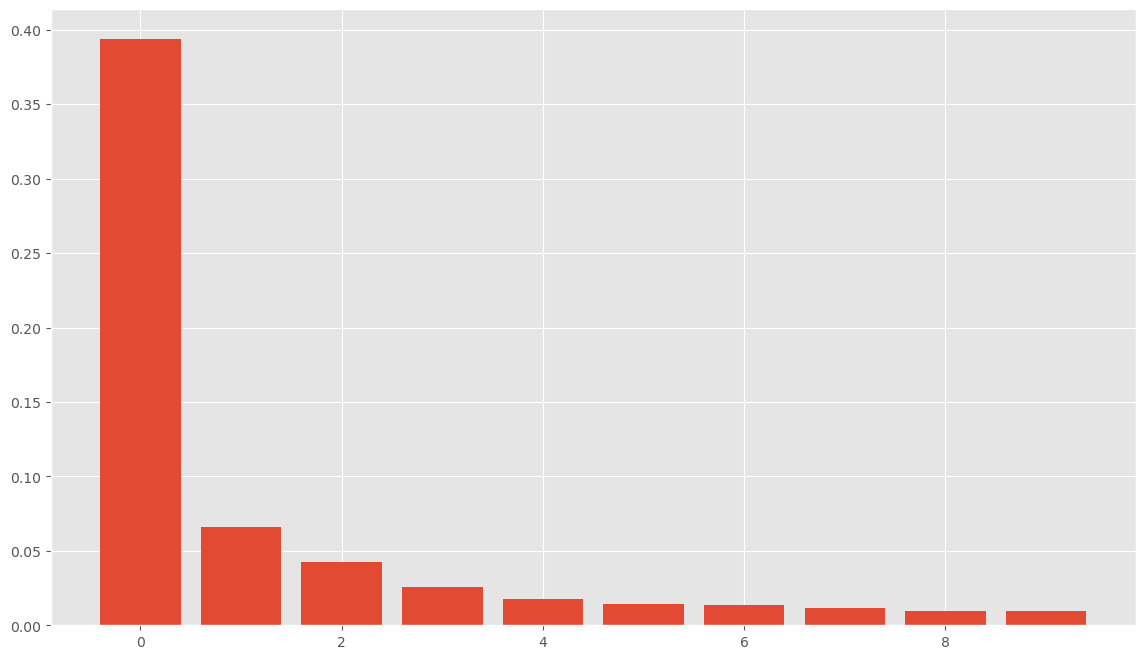

In [22]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

You will see that the first factor dominates. The precise definition of each factor in a latent model is unknown, however we can guess at the likely interpretation.

## Factor Betas
Implement `factor_betas` to get the factor betas from the PCA model.

In [23]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    
    #TODO: Implement function
    factor_betas = pd.DataFrame(
        data=pca.components_.T,
        index=factor_beta_indices,
        columns=factor_beta_columns
    )
    return factor_betas

### View Data
Let's view the factor betas from this model.

In [24]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, five_year_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas']

,0,1,2,3,4,5,6,7,8,9
A,-0.040152,-0.048640,0.023141,-0.012592,-0.005570,-0.041204,0.000884,0.004114,-0.026044,-0.003365
AAPL,-0.043033,-0.064188,0.000610,-0.025658,0.010627,-0.000789,0.051421,-0.008792,-0.007654,-0.030594
ABBV,-0.022540,-0.002694,0.052742,-0.018904,0.027854,0.020100,0.034178,0.000902,-0.027193,-0.018013
ABNB,-0.033936,-0.048182,-0.104000,0.028175,-0.025081,-0.126144,0.019209,0.001754,0.082177,-0.050414
ABT,-0.029117,-0.045214,0.061413,-0.003405,0.010575,-0.034722,0.034680,0.007175,-0.006373,-0.010198
...,...,...,...,...,...,...,...,...,...,...
XYL,-0.049133,-0.015828,0.033755,0.016549,-0.040274,0.005485,-0.024382,-0.013761,0.007576,0.035944
YUM,-0.037370,-0.005601,0.019960,0.026317,0.044897,0.041378,-0.025873,-0.006228,-0.007940,-0.014932
ZBH,-0.043680,0.014314,0.008068,0.024180,0.061395,0.000887,-0.003925,0.020211,-0.019740,0.023681
ZBRA,-0.057646,-0.050499,-0.016460,-0.010968,-0.059100,-0.058748,-0.004881,-0.002883,0.005989,-0.000283


## Factor Returns
Implement `factor_returns` to get the factor returns from the PCA model using the returns data.

In [25]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    #TODO: Implement function
    factor_returns = pd.DataFrame(data=pca.transform(returns),
                                  index=factor_return_indices,
                                  columns=factor_return_columns)

    return factor_returns

### View Data
Let's see what these factor returns looks like over time.

<Axes: xlabel='Date'>

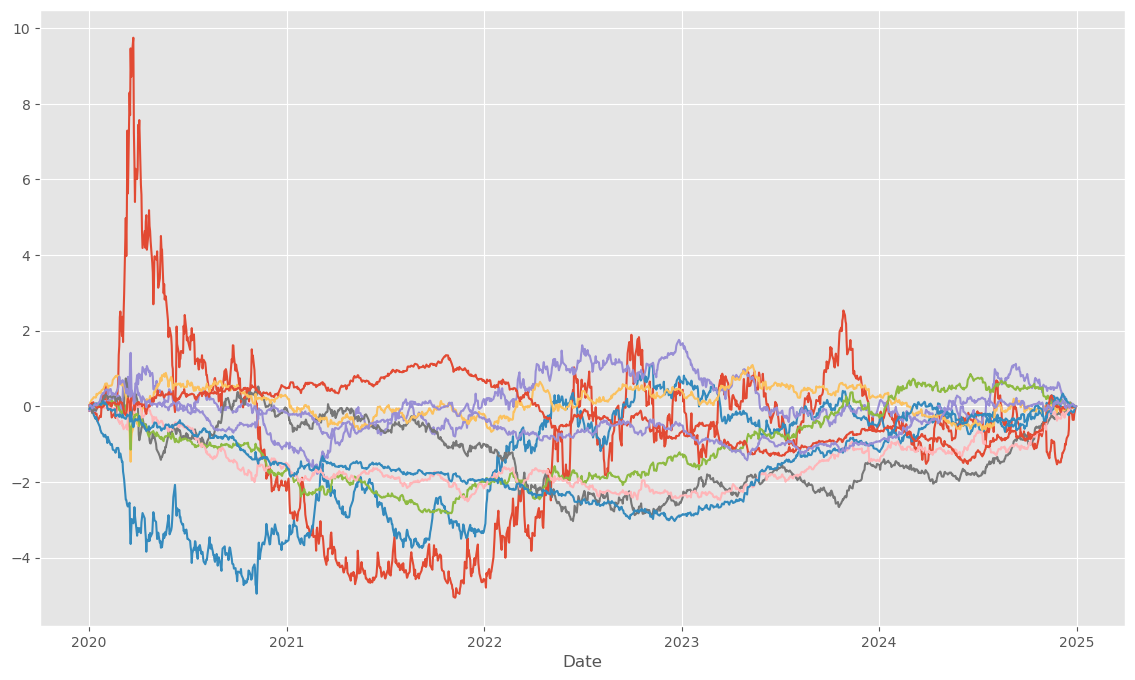

In [26]:
risk_model['factor_returns'] = factor_returns(
    pca,
    five_year_returns,
    five_year_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None)

## Factor Covariance Matrix
Implement `factor_cov_matrix` to get the factor covariance matrix.

In [27]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    """
    
    #TODO: Implement function
    factor_cov_matrix = np.diag(factor_returns.var(axis=0, ddof=1)*ann_factor)
    return factor_cov_matrix

### View Data

In [28]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[22.69664361,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  3.78541216,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  2.44904454,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.46724633,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.00468399,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.82627918,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.76910481,  0.        

## Idiosyncratic Variance Matrix
Implement `idiosyncratic_var_matrix` to get the idiosyncratic variance matrix.

In [29]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    
    #TODO: Implement function
    common_returns = pd.DataFrame(data=factor_returns.dot(factor_betas.T),
                                  index=returns.index,
                                  columns=returns.columns)
    
    residuals = returns - common_returns
    
    idiosyncratic_var_matrix = pd.DataFrame(np.diag(np.var(residuals)) * ann_factor,
                                            returns.columns,
                                            returns.columns)

    return idiosyncratic_var_matrix

### View Data

In [30]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(five_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix']

/Users/martinescobarsalgueiro/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Ticker,A,AAPL,ABBV,ABNB,ABT,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Ticker,,,,,,,,,,,,,,,,,,,,,
A,0.039081,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
AAPL,0.000000,0.039074,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
ABBV,0.000000,0.000000,0.039924,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
ABNB,0.000000,0.000000,0.000000,0.112605,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
ABT,0.000000,0.000000,0.000000,0.000000,0.029947,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.034778,0.000000,0.000000,0.000000,0.00000
YUM,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.029726,0.000000,0.000000,0.00000
ZBH,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.048457,0.000000,0.00000


## Idiosyncratic Variance Vector
Implement `idiosyncratic_var_vector` to get the idiosyncratic variance Vector.

In [31]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """
    
    #TODO: Implement function
    idiosyncratic_var_vector = pd.DataFrame(np.diag(idiosyncratic_var_matrix),
                        index = returns.columns)
    
    return idiosyncratic_var_vector

### View Data

In [32]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(five_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector']

,0
Ticker,
A,0.039081
AAPL,0.039074
ABBV,0.039924
ABNB,0.112605
ABT,0.029947
...,...
XYL,0.034778
YUM,0.029726
ZBH,0.048457


## Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [33]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    #TODO: Implement function
    X = weights
    B = factor_betas
    F = factor_cov_matrix
    S = idiosyncratic_var_matrix
    
    predicted_portfolio_risk = np.sqrt(X.T.dot(B.dot(F).dot(B.T)+S).dot(X))
    
    return predicted_portfolio_risk[0][0]

### View Data
Let's see what the portfolio risk would be if we had even weights across all stocks.

In [34]:
universe_tickers = five_year_returns.columns.tolist()

In [35]:
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)
all_weights

,0
A,0.0025
AAPL,0.0025
ABBV,0.0025
ABNB,0.0025
ABT,0.0025
...,...
XYL,0.0025
YUM,0.0025
ZBH,0.0025
ZBRA,0.0025


In [36]:
predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.22517237505454257

# Create Alpha Factors
With the profile risk calculated, it's time to start working on the alpha factors. In this project, we'll create the following factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Factor
- Overnight Sentiment Smoothed Factor

## Momentum 1 Year Factor
Each factor will have a hypothesis that goes with it. For this factor, it is "Higher past 12-month (252 days) returns are proportional to future return." Using that hypothesis, we've generated this code:

In [116]:
# Function to calculate 1-year returns
def yearly_returns(close):
    returns = close.pct_change(252)  # 252 trading days in a year
    return returns

# Function to calculate demeaned, ranked, and z-scored factors by sector
#def calculate_factors(close, sector):
def factors_returns(close):    
    # Calculate 1-year returns
    returns = yearly_returns(close)
    
    # Group by sector and calculate demeaned factors
    mean_returns = returns.mean(axis=1)
    demeaned = returns.sub(mean_returns, axis=0)
    #demeaned = returns.groupby(sector, axis=1).transform(lambda x: x - x.mean(axis=1))

    # Rank and z-score the demeaned factors
    ranked = demeaned.rank(axis=1)
    # z score
    #mean_rank = ranked.mean(axis=1)
    #z_scored = ranked.sub(mean_rank, axis=0) / ranked.std(axis=1)
    # Calculate z-scores across rows (dates)
    ranked_mean = ranked.mean(axis=1)
    ranked_std = ranked.std(axis=1)
    z_scored = ranked.sub(ranked_mean, axis=0).div(ranked_std, axis=0)
    
    # Create a DataFrame with the date index and stock tickers as columns
    #z_scored_df = pd.DataFrame(z_scored, index=close.index, columns=close.columns)
    
    return z_scored
    #return z_scored


In [ ]:
sector.tail(20)

In [ ]:
factors_returns(close)

In [47]:
from zipline.pipeline.factors import Returns

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

## Mean Reversion 5 Day Sector Neutral Factor
Now it's time for you to implement `mean_reversion_5day_sector_neutral` using the hypothesis "Short-term outperformers(underperformers) compared to their sector will revert." Use the returns data from `universe`, demean using the sector data to partition, rank, then converted to a zscore.

In [48]:
def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """
    
    #TODO: Implement function
    
    factor = -Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()
    
    return factor

### View Data
Let's see what some of the factor data looks like. For calculating factors, we'll be looking back 2 years.

**Note:** _Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open._

In [ ]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
sector = project_helper.Sector()
window_length = 5

pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral(window_length, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

## Mean Reversion 5 Day Sector Neutral Smoothed Factor
Taking the output of the previous factor, let's create a smoothed version. Implement `mean_reversion_5day_sector_neutral_smoothed` to generate a mean reversion 5 fay sector neutral smoothed factor. Call the `mean_reversion_5day_sector_neutral` function to get the unsmoothed factor, then use `SimpleMovingAverage` function to smooth it. You'll have to apply rank and zscore again.

In [ ]:
from zipline.pipeline.factors import SimpleMovingAverage

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral smoothed factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral smoothed factor
    """
    
    #TODO: Implement function
    factor_uns = mean_reversion_5day_sector_neutral(window_length, universe, sector)
    factor = (
        SimpleMovingAverage(inputs=[factor_uns], window_length=window_length).
        rank().
        zscore()
    )
    
    return factor


project_tests.test_mean_reversion_5day_sector_neutral_smoothed(mean_reversion_5day_sector_neutral_smoothed)

### View Data
Let's see what some of the smoothed data looks like.

In [ ]:
pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

## Overnight Sentiment Factor
For this factor, were using the hypothesis from the paper [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010).

In [30]:
from zipline.pipeline.data import USEquityPricing


class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]

        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

        
def overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    return TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Overnight Sentiment Smoothed Factor
Just like the factor you implemented, we'll also smooth this factor.

In [31]:
def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Combine the Factors to a single Pipeline
With all the factor implementations done, let's add them to a pipeline.

In [ ]:
universe = AverageDollarVolume(window_length=120).top(500)
sector = project_helper.Sector()

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')
pipeline.add(
    overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors.head()

# Evaluate Alpha Factors
*Note:* _We're evaluating the alpha factors using delay of 1_
## Get Pricing Data

In [33]:
import alphalens as al

assets = all_factors.index.levels[1].values.tolist()
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets,
    factor_start_date,
    universe_end_date)

## Format alpha factors and pricing for Alphalens
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. In this next cell, we'll do just that.

In [ ]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

## Quantile Analysis
### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

In [ ]:
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot()

### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

In [ ]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

What do you observe?

- None of these alphas are **strictly monotonic**; this should lead you to question why this is? Further research and refinement of the alphas needs to be done. What is it about these alphas that leads to the highest ranking stocks in all alphas except MR 5D smoothed to *not* perform the best.
- The majority of the return is coming from the **short side** in all these alphas. The negative return in quintile 1 is very large in all alphas. This could also a cause for concern becuase when you short stocks, you need to locate the short; shorts can be expensive or not available at all.
- If you look at the magnitude of the return spread (i.e., Q1 minus Q5), we are working with daily returns in the 0.03%, i.e., **3 basis points**, neighborhood *before all transaction costs, shorting costs, etc.*. Assuming 252 days in a year, that's 7.56% return annualized. Transaction costs may cut this in half. As such, it should be clear that these alphas can only survive in an institutional setting and that leverage will likely need to be applied in order to achieve an attractive return.

## Turnover Analysis

Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**.

[alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

In [ ]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

## Sharpe Ratio of the Alphas

The last analysis we'll do on the factors will be sharpe ratio. Implement `sharpe_ratio` to calculate the sharpe ratio of factor returns.

In [ ]:
def sharpe_ratio(factor_returns, annualization_factor):
    """
    Get the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    
    #TODO: Implement function
    sharpe_ratio = factor_returns.mean()/factor_returns.std()*annualization_factor
    
    return sharpe_ratio


project_tests.test_sharpe_ratio(sharpe_ratio)

### View Data
Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [ ]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

## Question: What do you think would happen if we smooth the momentum factor? Would the performance increase, decrease, or no major change? Why?

_#TODO: Put Answer In this Cell_

**Answer:** The Momentum_1YR factor has a high FRA. Therefore, smoothing the factor might add little improvement. Additionally, the signal may become less reactive to trade changes

## The Combined Alpha Vector

To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. This is a area where machine learning can be very helpful. In this module, however, we will take the simplest approach of combination: simply averaging the scores from each alpha.

In [ ]:
selected_factors = all_factors.columns[[1, 2, 4]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
alphas = all_factors[['alpha_vector']]
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]
alpha_vector.head()

# Optimal Portfolio Constrained by Risk Model
You have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model. You'll be building thie optimizer for this portfolio. To help you out. we have provided you with an abstract class called `AbstractOptimalHoldings`.

In [41]:
from abc import ABC, abstractmethod


class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

In [ ]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        #TODO: Implement function
        objective = cvx.Minimize(-alpha_vector.T.values[0]*weights)
        
        return objective
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        #TODO: Implement function
        constraints = [
            risk <= self.risk_cap ** 2,
            np.array(factor_betas.T) * weights <= self.factor_max,
            np.array(factor_betas.T) * weights >= self.factor_min, 
            sum(weights) == 0, 
            sum(cvx.abs(weights)) <= 1, 
            weights >= self.weights_min, 
            weights <= self.weights_max
        ]

        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min


project_tests.test_optimal_holdings_get_obj(OptimalHoldings)
project_tests.test_optimal_holdings_get_constraints(OptimalHoldings)

### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

In [ ]:
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Yikes. It put most of the weight in a few stocks.

In [ ]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. We'll create a new class called `OptimalHoldingsRegualization` which gets its constraints from the `OptimalHoldings` class. In this new class, implement the `_get_obj` function to return a CVXPY objective function that maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

**Note:** * $ \lambda $ is located in `self.lambda_reg`. *

In [ ]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        a_max = -(alpha_vector.T.values[0] * weights)
        reg = self.lambda_reg * cvx.pnorm(weights,2)
        objective = cvx.Minimize(a_max + reg)
        
        return objective

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min
        

project_tests.test_optimal_holdings_regualization_get_obj(OptimalHoldingsRegualization)

### View Data

In [ ]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Nice. Well diversified.

In [ ]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. For this next class, `OptimalHoldingsStrictFactor`, you'll implement the `_get_obj` function to minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

In [ ]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        x = (alpha_vector - alpha_vector.mean())/sum(abs(alpha_vector.values))
        
        objective = cvx.Minimize(cvx.norm(weights-x.values.reshape(-1,), 2))
        
        return objective


project_tests.test_optimal_holdings_strict_factor_get_obj(OptimalHoldingsStrictFactor)

### View Data

In [ ]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

In [ ]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade. You can continue to the next section while you wait for feedback.